Pipeline do trabalho:
- Capa e contracapa, sumário e resumo:
- Introdução:
    + Apresentação do trabalho;
    + Detalhamento dos dados, motivação e afins.
- Dados e metodologia:
    + Exploração inicial dos dados (primeiras visualizações gráficas e estatísticas descritivas básicas) e realização dos testes de raiz (adf,pp,kpss)
    + Decomposição e filtros nos dados (tirar tendência e tirar sazonalidade), e após isso refazer testes de raiz para confirmar sua não existência.
- OBS: Aqui já sabemos que a série possui sim uma raiz unitária e sazonalidade significativa, a ideia é seguir retirando esses dois componentes. A raiz deve ser retirada devido ao fato de estarmos trabalhando com modelos estacionários, com a diferenciação a série passa a ser estacionaria e não perde quantidade significativa de informação então ainda podemos tirar informações dela (mais especificamente perde apenas um grau de liberdade dos 150 aproximadamente que temos). Quanto a sazonalidade na base acho que a melhor abordagem e sua retirada, uma vez que ela torna o processo de previsão muito mais complexo e pode levar a interpretações erradas quando tivermos os resultados dos modelos se não a incorporarmos direito, portanto deve ser filtrada também, podemos fazer isso bem de boa com o pacote statsmodels.
O Milton falou que devemos “colocar a série temporal em perspectiva ao problema a que se referem, principalmente em sintonia com a política econômica brasileira”, então aqui acho válido relacionar o trabalho com políticas públicas de alguma forma.
- Ajuste de qual modelo selecionado para representação dos dados (Começamos com modelos maiores e redução até melhor modelo enxuto)
    + Avaliação do modelo com análise de resíduos (normalidade do erro, autocorrelação, heterocedasticidade)
    + Métricas de performance do modelo (MSE,RMSE...)
- OBS: Aqui é uma parte mais chatinha no sentido de que temos de interpretar o gráfico e entender que modelo melhor representa nossa série. Acontece que fica algo fraco se so falarmos “ah é tal modelo”, então o que a Roseli por exemplo pedia para fazer é analisar o maior modelo que se encaixaria no que vemos nas funções FAC e FACP. Na minha interpretação o maior modelo que poderíamos tentar é um ARMA(4,4), e irmos fazendo outros menores até encontrar o que tenha a melhor relação dos itens avaliadores de modelo ( estatísticas de erro acima citadas)(Vamos começar com ARMA(4,4) e ir reduzindo até ARMA(1,1) depois AR e MA de 4 até 1, isso nos dará mais robustez para colocarmos qual foi o melhor modelo dentre vários que tem uma boa explicação da realidade sem ter tanto overfitting por ser demasiadamente grande) Outra coisa é achar uma função que acha os lags ótimos para os modelos, não sei como fazer isso no python na prática, porém essa é uma ferramenta que existe no Eviews e portanto deve existir no python tbm. Com ela o algoritmo já encontra qual é o lag ótimo para começar a modelagem, ao invés de começar do 4 e ir descendo vai descendo a partir desse lag ótimo.. Daí teremos no final o melhor dos modelos para que possamos seguir com a previsão. Podemos sumarizar todas essas estatísticas em uma tabela e colocar para provar a robustez da decisão
- Resultados:
    + Previsão de período a frente e comparação com o que de fato foi
- Conclusão
- Apêndice com informações a mais como ARCH, GARCH (OPICIONAL])
=> OBS: Não acho que seja necessário modelar a variância para que o trabalho tenha boa performance quanto a nota, porém podemos fazer caso seja de consentimento geral. Nesse caso imagino incluir essa parte em um apêndice uma vez que foge de certa forma da descrição que o Milton deu do que deve ser feito no corpo principal do trabalho.



In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose, STL #Dessazonalização da série forma multiplicatica e aditiva(Media móvel) e por STL
from sklearn.metrics import mean_absolute_error, mean_squared_error # Medidas de desempenho por erro
from arch.unitroot import PhillipsPerron,ADF,KPSS,DFGLS #testes de raiz unitária


diretorio = "C:/Users/DESKTOP 15/Desktop/trab_eco_3/"
dados = []

for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.csv'):
        caminho = os.path.join(diretorio, arquivo)
        basesprf = pd.read_csv(caminho, sep = ';', encoding = 'ISO-8859-1')
        dados.append(basesprf)

acidentes = pd.concat(dados, ignore_index = True)

acidentes.info() #Observações: 322012

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322013 entries, 0 to 322012
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      322013 non-null  float64
 1   pesid                   164889 non-null  float64
 2   data_inversa            322013 non-null  object 
 3   dia_semana              322013 non-null  object 
 4   horario                 322013 non-null  object 
 5   uf                      322013 non-null  object 
 6   br                      321529 non-null  float64
 7   km                      321529 non-null  object 
 8   municipio               322013 non-null  object 
 9   causa_acidente          322013 non-null  object 
 10  tipo_acidente           321944 non-null  object 
 11  classificacao_acidente  322013 non-null  object 
 12  fase_dia                322013 non-null  object 
 13  sentido_via             322013 non-null  object 
 14  condicao_metereologi

In [131]:
#Tirando duplicados
acidentes_semdup = acidentes[['id', 'data_inversa']].drop_duplicates()
acd_sdcopia = acidentes_semdup.copy()

#Conversão em datetime
acd_sdcopia['data_inversa'] = pd.to_datetime(acd_sdcopia['data_inversa'], format = 'mixed')
acd_sdcopia.info() 


<class 'pandas.core.frame.DataFrame'>
Index: 226457 entries, 0 to 322012
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            226457 non-null  float64       
 1   data_inversa  226457 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.2 MB


Dias:  1095


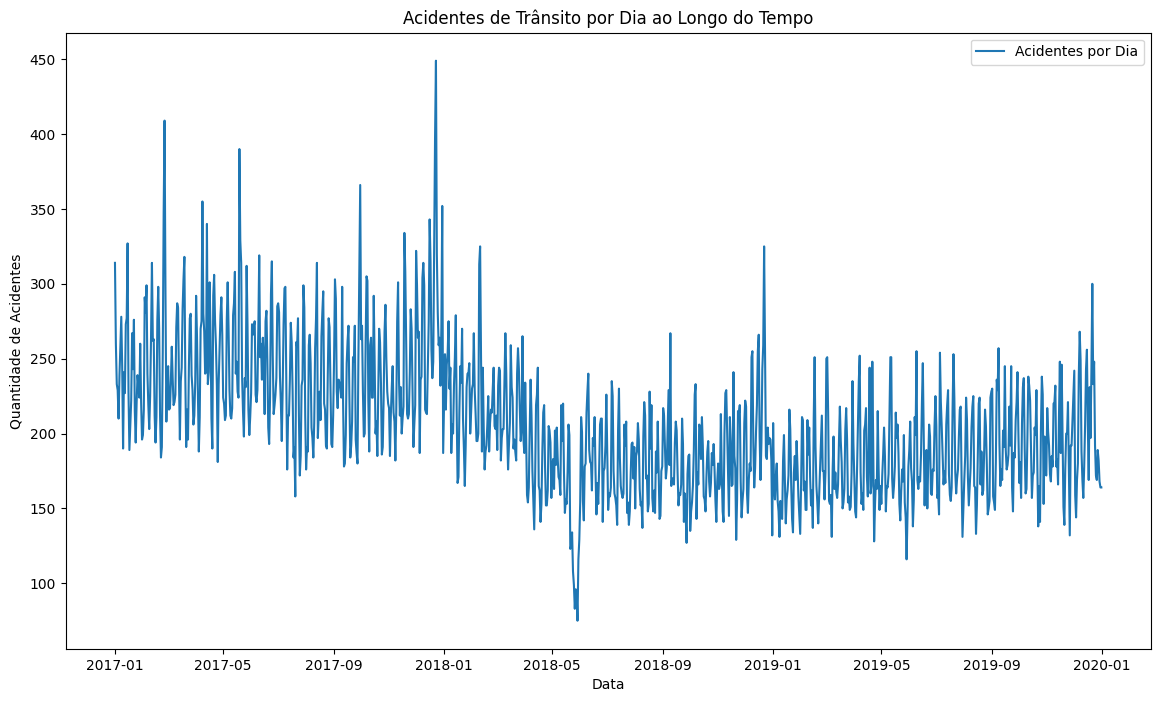

In [132]:
#Abordagem diária

#Contagem de acidentes por dia
acd_dia = acd_sdcopia.groupby('data_inversa').size().reset_index(name='Qtd_Acidentes_Dia')

#Contagem de dias
dias = len(acd_dia)
print("Dias: " , dias)

#Gráfico de acidentes por dia
plt.figure(figsize=(14, 8))
sns.lineplot(x='data_inversa', y='Qtd_Acidentes_Dia', data = acd_dia, label='Acidentes por Dia')
plt.title('Acidentes de Trânsito por Dia ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acidentes')

plt.show()


A abordagem diária nao é interessante, muita variação brusca. Temos de justificar a escolha de um período maior. No caso será uma abordagem por semana que trouxe uma boa visualização do gráfico. A mensal ficou mais ou menos a mesma coisa e sacrificou muita informação da base, portanto a abordagem escolhida foi a semanal

Semanas:  158


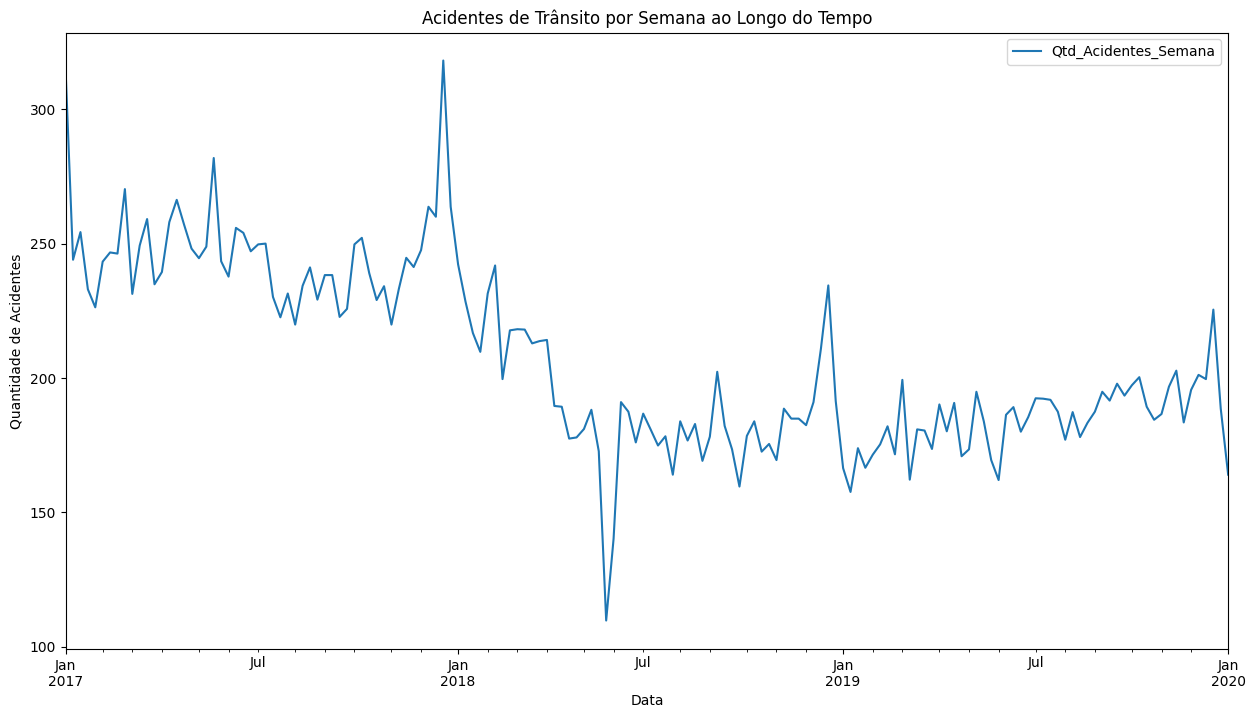

In [133]:
#Abordagem Semanal

#Variável de Acidentes em Cada Semana
acd_sdcopia['Qtd_Acidentes_Semana'] = acd_sdcopia['data_inversa'].dt.to_period('W').astype(str)

#Contagem de Acidentes por Semana
acd_sem = acd_sdcopia.groupby('data_inversa').count()
acd_sem = acd_sem.resample('W').mean()
acd_sem['id'] = acd_sem['Qtd_Acidentes_Semana']
acd_sem = acd_sem.drop('id', axis=1)

#Contagem de Semanas
semanas = len(acd_sem)
print("Semanas: ", semanas)

#Gráfico de Acidentes por Semana
acd_sem.plot(figsize = (15,8))
plt.title('Acidentes de Trânsito por Semana ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acidentes')

plt.show()

In [134]:
acd_sem.head()

,Qtd_Acidentes_Semana
data_inversa,
2017-01-01,314.000000
2017-01-08,244.000000
2017-01-15,254.285714
2017-01-22,233.000000
2017-01-29,226.285714


36


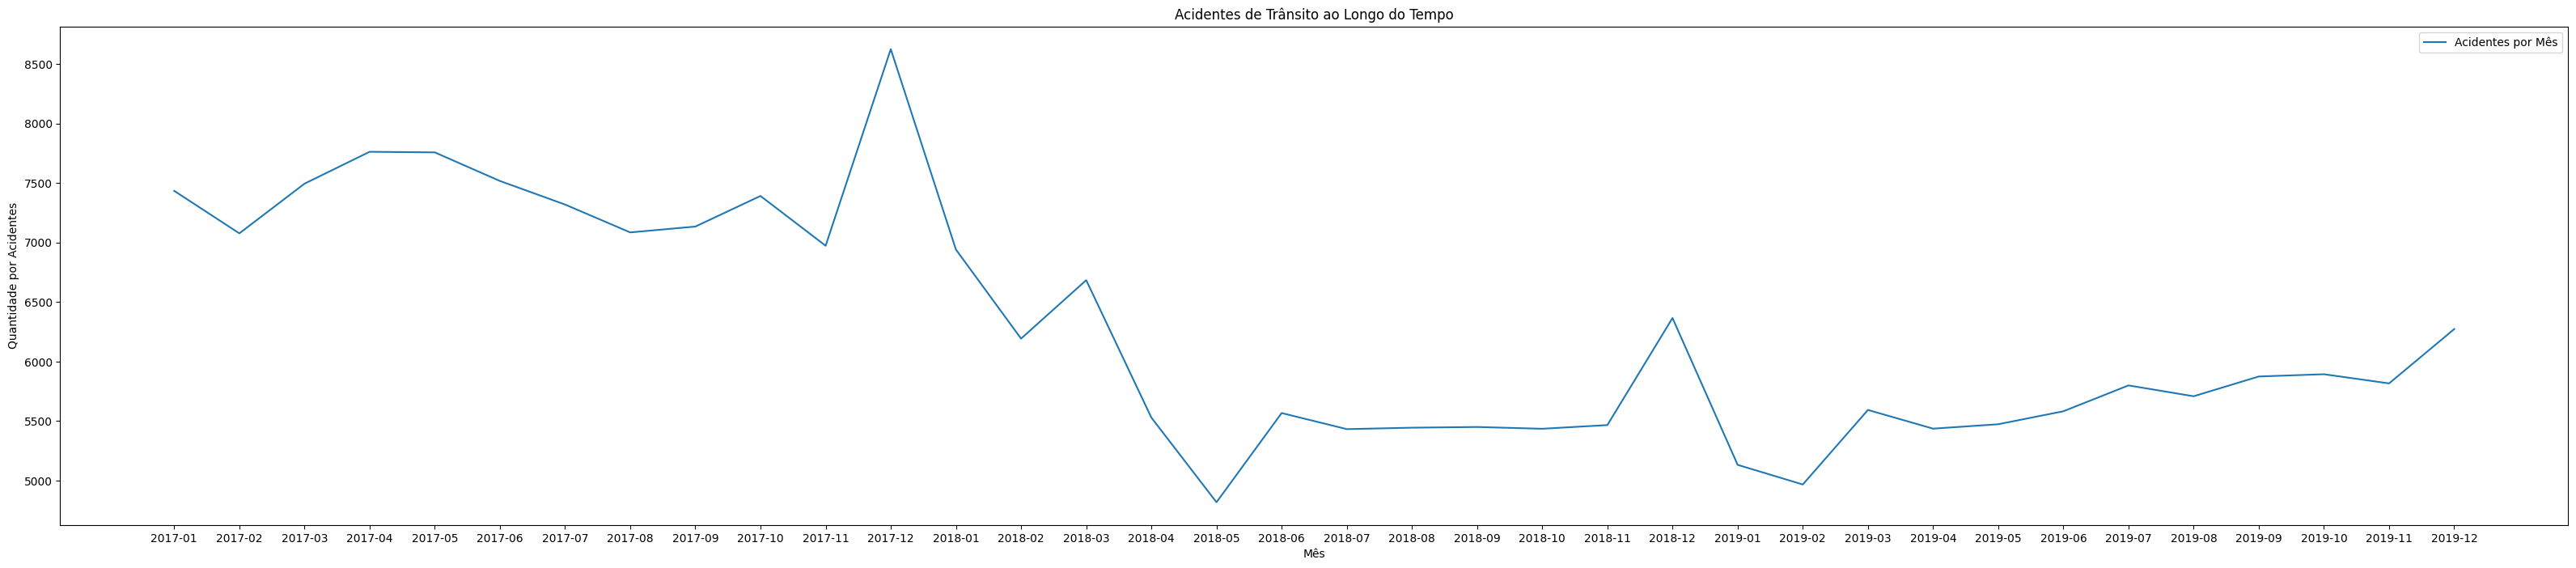

In [135]:
#Abordagem Mensal
#Variável ano_mes
acd_sdcopia['ano_mes'] = acd_sdcopia['data_inversa'].dt.to_period('M').astype(str)

#Contagem de acidentes por ano e mês
acd_anomes = acd_sdcopia.groupby('ano_mes').size().reset_index(name='Qtd_Acidentes_Mes')

#Contagem de Meses
meses = len(acd_anomes)
print(meses)

#Gráfico de acidentes por mês/ano
plt.figure(figsize=(40,8))
sns.lineplot(x = 'ano_mes', y = 'Qtd_Acidentes_Mes', data = acd_anomes, label = 'Acidentes por Mês')
plt.title('Acidentes de Trânsito ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Quantidade por Acidentes')

plt.show()

Comparação dos Modelos
- Modelo Aditivo: Útil quando a amplitude da sazonalidade é constante ao longo do tempo.
- Modelo Multiplicativo: Melhor quando a amplitude da sazonalidade varia com o nível da série temporal.
- STL: É um modelo mais robusto que peca em simplicidade, porém tenta utilizar de métodos mais complexos para fazer a decomposição

Decomposição Aditiva e Multiplicativa

- Modelo Aditivo:
    - Assumimos que a série é a soma da tendência, sazonalidade e ruído.
    - Fórmula: $Y(t)=T(t)+S(t)+R(t)$

- Modelo Multiplicativo:
    - Assumimos que a série é o produto da tendência, sazonalidade e ruído.
    - Fórmula: $Y(t)=T(t)×S(t)×R(t)$

Portanto para a dessazonalização da série devemos retirar a parte de sazonalidade de cada um

Para o Modelo Aditivo:
Subtraímos o componente sazonal da série original.
Fórmula: $Y_{\text{dessazonalizado}}(t) = Y(t)−S(t)$

Para o Modelo Multiplicativo:
Dividimos a série original pelo componente sazonal.
Fórmula: $Y_{\text{dessazonalizado}}(t) = Y(t)/S(t)$
​
- O modelo STL também tem a amesma abordagem de itens por soma, a diferença fundamental entre o método STL (Seasonal and Trend decomposition using Loess) e o método de decomposição puramente aditivo está na abordagem utilizada para separar os componentes da série temporal.

No método de decomposição puramente aditivo, os componentes são simplesmente adicionados. Ou seja, a série temporal é decomposta em tendência, sazonalidade e resíduo, e esses componentes são adicionados para reconstruir a série original. A decomposição aditiva é adequada quando as variações dos componentes não são proporcionais ao nível da série. Por exemplo, se a amplitude da sazonalidade permanece constante ao longo do tempo, independentemente do nível da série, a abordagem aditiva seria apropriada.

Por outro lado, o método STL utiliza técnicas de suavização local (como Loess) para estimar os componentes de tendência e sazonalidade em cada ponto de tempo. Isso significa que os componentes de tendência e sazonalidade são ajustados de forma adaptativa, levando em consideração as flutuações locais na série. Portanto, o método STL é mais flexível e capaz de lidar com padrões mais complexos na série temporal, onde a amplitude da sazonalidade ou a forma da tendência podem variar ao longo do tempo.

- O método STL pode ser especialmente útil em várias situações:

- **Sazonalidade variável**: Quando a amplitude ou a forma da sazonalidade varia ao longo do tempo, o método STL, com sua capacidade de ajustar localmente a suavização, pode capturar essas variações de forma mais precisa do que uma abordagem de decomposição aditiva simples.

- **Tendência não linear**: Se a tendência da série não é linear e exibe padrões mais complexos, como curvas de crescimento ou declínio não lineares, o método STL pode se ajustar melhor a esses padrões do que uma decomposição aditiva.

- **Preservação de detalhes**: O método STL pode preservar melhor os detalhes de curto prazo da série original, enquanto ainda separa claramente os componentes de tendência e sazonalidade. Isso pode ser útil em análises que requerem a identificação precisa de mudanças abruptas ou eventos de curto prazo.

- **Robustez contra outliers**: O método STL pode ser mais robusto contra outliers extremos na série temporal, já que utiliza suavização local que pode ser menos sensível a valores extremos do que métodos de suavização global.

- **Padrões irregulares**: Se a série temporal exibe padrões irregulares ou inesperados que não podem ser facilmente modelados por uma decomposição aditiva simples, o método STL pode oferecer uma melhor capacidade de se adaptar a esses padrões devido à sua flexibilidade na suavização local.

Portanto, o método STL pode ser preferível em uma ampla variedade de situações em que a série temporal exibe complexidade na tendência, na sazonalidade ou na presença de outliers

Isso pode ajudar a entender pq la na frente o modelo stl vai ser a pior perfeormance, ele tenta abarcar muitas situações mas em uma série mais simples acaba gerando mais perda de informação do que ganho de robustez(Minha opinião)

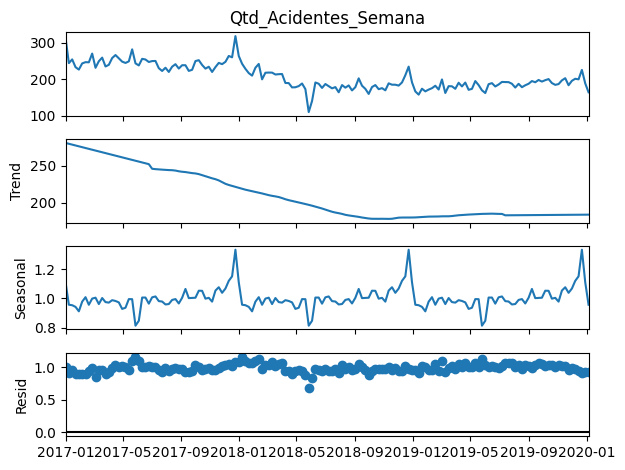

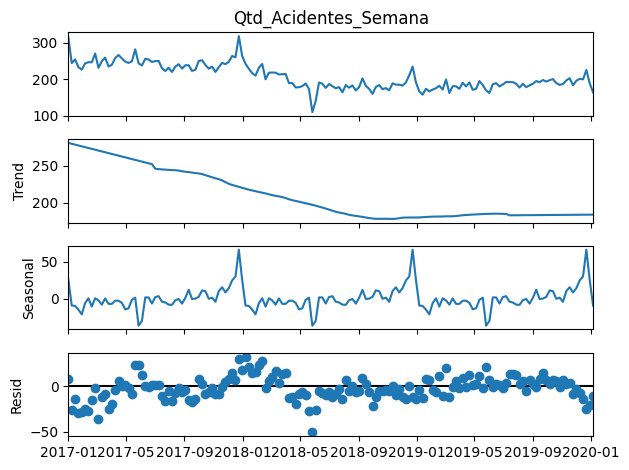

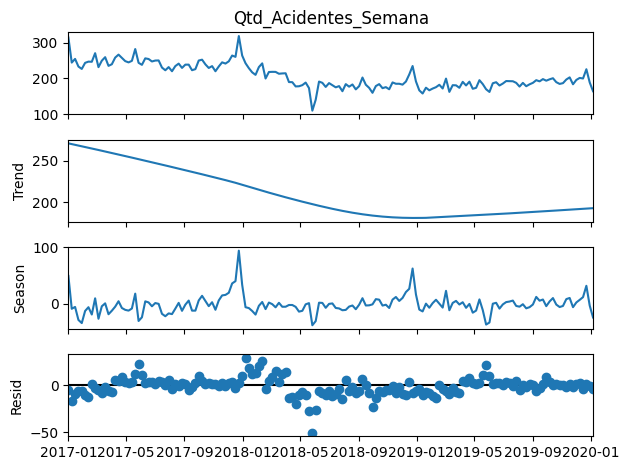

In [136]:
# Decomposições por adição
decomp_mult = seasonal_decompose(acd_sem['Qtd_Acidentes_Semana'],model = 'multiplicative', extrapolate_trend = 'freq', period = 52)
graf_mult = decomp_mult.plot()

# Decomposições por multiplicação
decomp_soma = seasonal_decompose(acd_sem['Qtd_Acidentes_Semana'],model = 'additive', extrapolate_trend = 'freq',period = 52)
graf_som = decomp_soma.plot()

# Decomposições por STL
decomp_stl = STL(acd_sem['Qtd_Acidentes_Semana']).fit()
graf_stl = decomp_stl.plot()

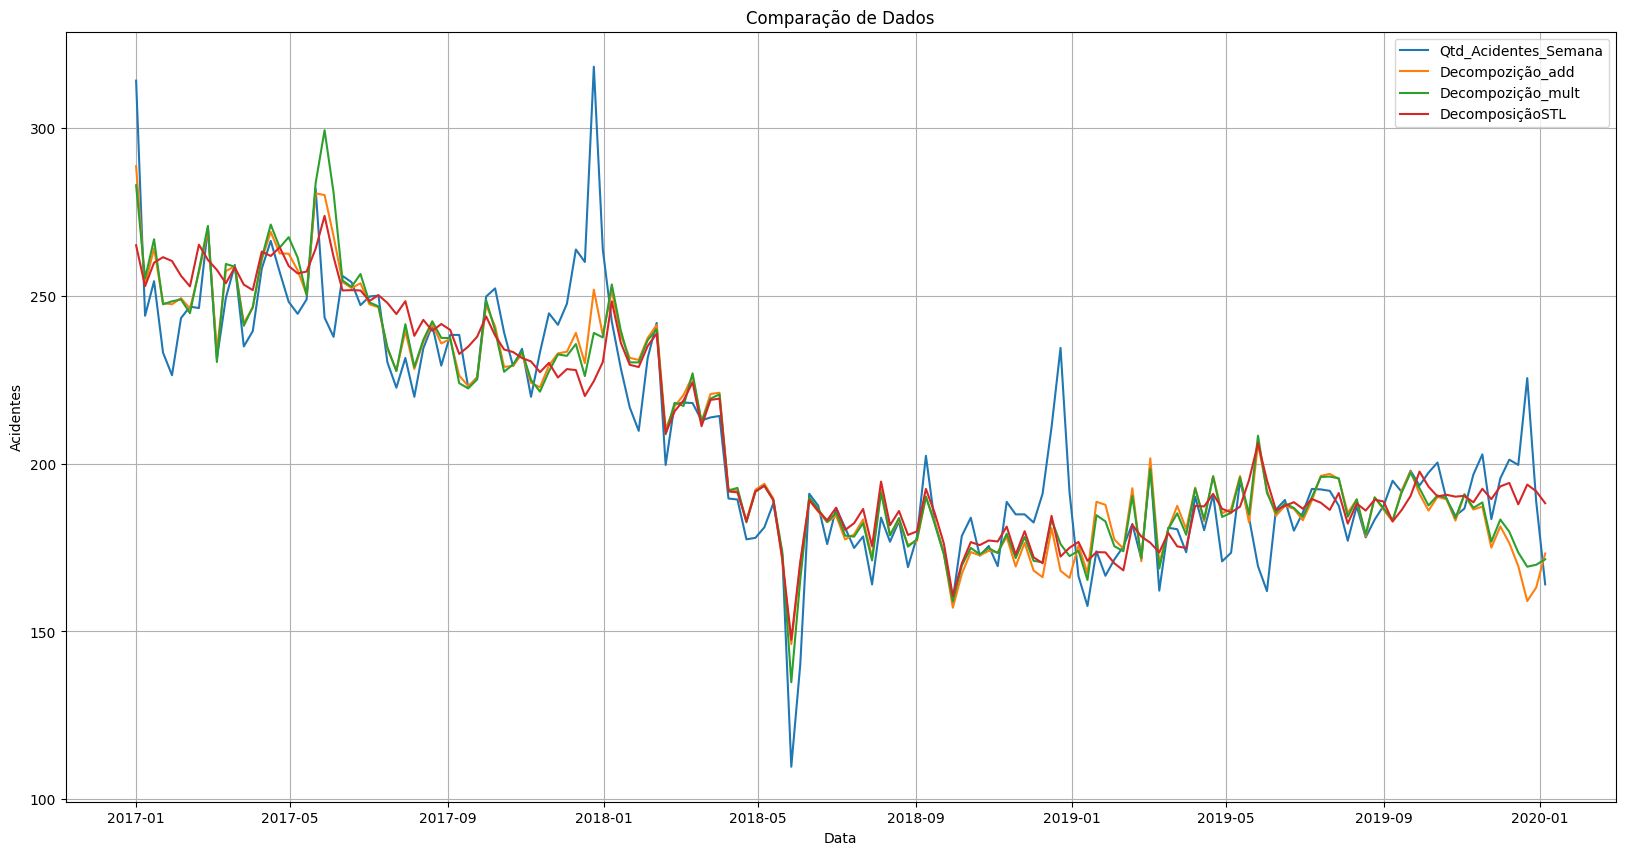

In [137]:
# Gerando série dessazonalizada para os três os métodos
acd_sem['Decompozição_add'] = acd_sem['Qtd_Acidentes_Semana'] - decomp_soma.seasonal
acd_sem['Decompozição_mult'] = acd_sem['Qtd_Acidentes_Semana']/decomp_mult.seasonal
acd_sem['Decompozição_STL'] = acd_sem['Qtd_Acidentes_Semana'] - decomp_stl.seasonal

# Gera um gráfico que mostra todos os resultados(Gráfico meio confuso, muita info junta, possível melhora)
plt.figure(figsize=(20, 10))
plt.plot(acd_sem['Qtd_Acidentes_Semana'], label='Qtd_Acidentes_Semana')
plt.plot(acd_sem['Decompozição_add'], label='Decompozição_add')
plt.plot(acd_sem['Decompozição_mult'], label='Decompozição_mult')
plt.plot(acd_sem['Decompozição_STL'], label='DecomposiçãoSTL')
plt.grid(True)
plt.title('Comparação de Dados')
plt.xlabel('Data')
plt.ylabel('Acidentes')
plt.legend()


- Agora a ideia é comparar os tres tipos de dessazonalização por medidas de erro, medidas de eficiencia de modelos. O pacote imporrtado acima possui já duas das fórmulas necessárias, uso elas e construo a do MAPE para que possa ser feita a comparação. 
- Breve descrição das medidas: 

- **Erro Absoluto Médio (MAE - Mean Absolute Error):**
   - O MAE é a média das diferenças absolutas entre os valores previstos e os valores observados. 
   - Ele fornece uma ideia da magnitude dos erros sem considerar sua direção (positivo ou negativo).
   - Quanto menor o MAE, melhor o desempenho do modelo. 

- **Raiz do Erro Quadrático Médio (RMSE - Root Mean Squared Error):**
   - O RMSE é a raiz quadrada da média dos quadrados das diferenças entre os valores previstos e os valores observados.
   - Ele penaliza mais fortemente os erros maiores, pois eles são elevados ao quadrado antes de serem somados e então tirada a raiz quadrada.
   - Também fornece uma medida da dispersão dos erros.
   - Novamente, quanto menor o RMSE, melhor o desempenho do modelo.

- **Erro Percentual Absoluto Médio (MAPE - Mean Absolute Percentage Error):**
   - O MAPE é uma medida de precisão de previsão expressa como uma porcentagem.
   - Ele calcula a média das diferenças percentuais absolutas entre os valores previstos e os valores observados em relação aos valores observados.
   - É útil porque dá uma ideia da magnitude dos erros em termos percentuais em relação aos valores observados.
   - Como os outros indicadores, quanto menor o MAPE, melhor o desempenho do modelo.

Interpretar esses indicadores depende do contexto específico do problema e das unidades dos dados. Em geral, você gostaria que todos esses indicadores fossem o mais baixo possível, indicando que seu modelo está fazendo previsões precisas. No entanto, é importante considerar o contexto do problema para determinar qual métrica é mais relevante para sua avaliação. Por exemplo, o MAE pode ser mais fácil de interpretar em termos absolutos, enquanto o MAPE pode ser mais útil quando você precisa entender a precisão relativa das previsões em relação aos valores observados.

In [138]:
# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculando as métricas para a série dessazonalizada aditiva
mae_add = mean_absolute_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_add'])
rmse_add = np.sqrt(mean_squared_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_add']))
mape_add = mean_absolute_percentage_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_add'])

# Calculando as métricas para a série dessazonalizada multiplicativa
mae_mult = mean_absolute_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_mult'])
rmse_mult = np.sqrt(mean_squared_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_mult']))
mape_mult = mean_absolute_percentage_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_mult'])

# Calculando as métricas para a série dessazonalizada aditiva
mae_stl = mean_absolute_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_STL'])
rmse_stl = np.sqrt(mean_squared_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_STL']))
mape_stl = mean_absolute_percentage_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_STL'])

# Mostra as métricas de erro para comparação
print(f"Modelo Aditivo - MAE: {mae_add}, RMSE: {rmse_add}, MAPE: {mape_add}%")
print(f"Modelo Multiplicativo - MAE: {mae_mult}, RMSE: {rmse_mult}, MAPE: {mape_mult}%")
print(f"Modelo STL - MAE: {mae_stl}, RMSE: {rmse_stl}, MAPE: {mape_stl}%")

Modelo Aditivo - MAE: 9.603258845834974, RMSE: 15.070333578431335, MAPE: 4.712783762337046%
Modelo Multiplicativo - MAE: 9.388852815401322, RMSE: 15.202192387235472, MAPE: 4.483399340078114%
Modelo STL - MAE: 10.640858010412805, RMSE: 16.20307001909135, MAPE: 5.085297587803567%


Precisamos que esses erros tenham algum valor, uma vez que queremos uma série de fato diferente da original, ela deve suavizar os spikes decorrentes da sazonalidade, porém mantendo a característica original e fidedignidade à série. Em suma eles não podem ser zero mas continua válido o raciocínio de quanto menos melhor.
A escolha do modelo foi pelo de adição, uma vez que gera os menores indices num geral.

Com a série dessazonalizada podemos continuar com a progressão do trabalho e partir para a análise da estacionariedade da série, uma vez que o trabalho se apresenta como aplicação de modelos estacionários temos de garantir a estacionariedade da série para continuar.

In [139]:
# Criação do objeto que será usado para testes futuros
acddes_sem = acd_sem[['Decompozição_add']].copy()
acddes_sem.head()

,Decompozição_add
data_inversa,
2017-01-01,288.513812
2017-01-08,253.194761
2017-01-15,264.060389
2017-01-22,247.746468
2017-01-29,247.412858


In [140]:
# Os testes realizados serão ADF- aumentado, Philip-Perron e KPSS
# Todos os métodos aqui apresentados possuem dois argumentos que serão úteis: trend = "ct" e lags = , devemos fazer todos esses

dfgls = DFGLS(acddes_sem, trend="ct")
print(dfgls.summary().as_text())

dfgls = DFGLS(acddes_sem)
print(dfgls.summary().as_text())

pp = PhillipsPerron(acddes_sem)
print(pp.summary().as_text())

pp = PhillipsPerron(acddes_sem, trend="ct")
print(pp.summary().as_text())

kpss = KPSS(acddes_sem)#hipotese nula se inverte
print(kpss.summary().as_text())

kpss = KPSS(acddes_sem, trend="ct")
print(kpss.summary().as_text())

      Dickey-Fuller GLS Results      
Test Statistic                 -1.552
P-value                         0.551
Lags                                7
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.55 (1%), -2.97 (5%), -2.68 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                  0.655
P-value                         0.870
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -2.70 (1%), -2.08 (5%), -1.76 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.679
P-value                         0.078
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.8

Uma coisa que vi na documentação do pacote:
- The ADF assumes residuals are white noise, and that the number of lags is sufficient to pick up any dependence in the data.

Vamos interpretar os resultados dos testes de raiz unitária e estacionariedade que você forneceu:

### Testes de Dickey-Fuller GLS

#### Com tendência constante e linear
- **Test Statistic (Estatística do Teste)**: -1.552
- **P-value**: 0.551
- **Critical Values (Valores Críticos)**: -3.55 (1%), -2.97 (5%), -2.68 (10%)
- **Interpretação**: 
  - A estatística do teste (-1.552) é maior que todos os valores críticos, e o p-value (0.551) é maior que os níveis de significância comuns (0.01, 0.05, 0.10). 
  - Portanto, não rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série não é estacionária.

#### Com tendência constante
- **Test Statistic (Estatística do Teste)**: 0.655
- **P-value**: 0.870
- **Critical Values (Valores Críticos)**: -2.70 (1%), -2.08 (5%), -1.76 (10%)
- **Interpretação**: 
  - A estatística do teste (0.655) é maior que todos os valores críticos, e o p-value (0.870) é maior que os níveis de significância comuns.
  - Portanto, não rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série não é estacionária.

### Testes de Phillips-Perron

#### Com tendência constante
- **Test Statistic (Estatística do Teste)**: -2.679
- **P-value**: 0.078
- **Critical Values (Valores Críticos)**: -3.47 (1%), -2.88 (5%), -2.58 (10%)
- **Interpretação**: 
  - A estatística do teste (-2.679) é maior que os valores críticos de 1% e 5%, mas menor que o valor crítico de 10%. O p-value (0.078) é ligeiramente maior que 0.05, mas menor que 0.10.
  - Dependendo do nível de significância adotado, pode haver uma rejeição fraca da hipótese nula. A série é possivelmente estacionária ao nível de significância de 10%, mas não a níveis mais rigorosos.

#### Com tendência constante e linear
- **Test Statistic (Estatística do Teste)**: -5.054
- **P-value**: 0.000
- **Critical Values (Valores Críticos)**: -4.02 (1%), -3.44 (5%), -3.14 (10%)
- **Interpretação**: 
  - A estatística do teste (-5.054) é menor que todos os valores críticos e o p-value é 0.000.
  - Rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série é estacionária.

### Testes KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

#### Com tendência constante
- **Test Statistic (Estatística do Teste)**: 1.488
- **P-value**: 0.000
- **Critical Values (Valores Críticos)**: 0.74 (1%), 0.46 (5%), 0.35 (10%)
- **Interpretação**: 
  - A estatística do teste (1.488) é maior que todos os valores críticos.
  - Rejeitamos a hipótese nula de que a série é estacionária. A série contém uma raiz unitária (não é estacionária).

#### Com tendência constante e linear
- **Test Statistic (Estatística do Teste)**: 0.320
- **P-value**: 0.001
- **Critical Values (Valores Críticos)**: 0.22 (1%), 0.15 (5%), 0.12 (10%)
- **Interpretação**: 
  - A estatística do teste (0.320) é maior que todos os valores críticos.
  - Rejeitamos a hipótese nula de que a série é estacionária. A série contém uma raiz unitária (não é estacionária).

### Resumo da Interpretação

1. **Dickey-Fuller GLS**: Ambos os testes (com tendência constante e linear e com apenas tendência constante) não rejeitam a hipótese nula de raiz unitária, indicando que a série não é estacionária.
2. **Phillips-Perron**: O teste com tendência constante sugere uma possível estacionariedade ao nível de 10%, mas não é conclusivo. O teste com tendência constante e linear rejeita a hipótese nula, indicando que a série é estacionária.
3. **KPSS**: Ambos os testes (com tendência constante e com tendência constante e linear) rejeitam a hipótese nula de estacionariedade, indicando que a série contém uma raiz unitária (não é estacionária).

<span style="line-height: 2;"><font size="3"><b>Diferenciação da Série Temporal Semanal: </font></b> Percebemos que a série temporal semanal exibe uma
leve tendência, o que a torna não estacionária pois sua média e variância não serão constantes ao longo do tempo. Isso é um problema para nós pois, como citado anteriormente, o modelo ARIMA exige que a série seja estacionária. A fim de tentar torná-la estacionária, podemos usar a primeira diferença dela, o que, em termos práticos, significa que geraremos uma nova série diferenciada em que cada valor corresponde à diferença entre o valor da observação no período <b>t</b> e o valor da observação no período <b>t-1</b>. </span><br> 

<span style="line-height: 2;">Traçando o gráfico da série diferenciada, observamos que, aparentemente, ela é estacionária como queriamos. Para checar se isso é verdade, podemos utilizar o Teste de Dickey-Fuller Aumentado.</span><br>

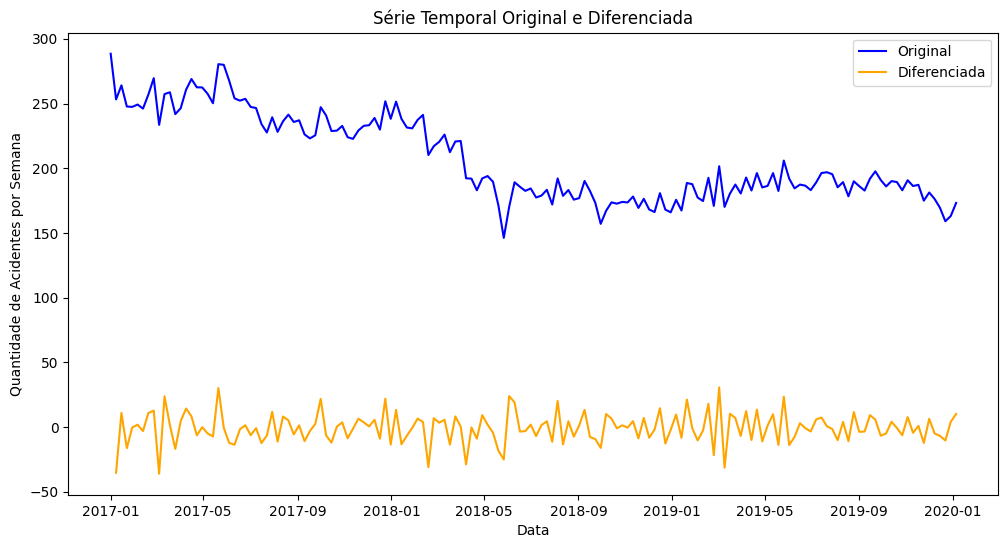

In [141]:
#1a Diferenciação da Série Temporal
acddes_sem['Qtd_Acidentes_Semana_1stDiff'] = acddes_sem['Decompozição_add'].diff()
acddes_sem = acddes_sem.drop("Decompozição_add",axis=1)
acddes_sem = acddes_sem.iloc[1:]

#Gráfico da série temporal original
plt.figure(figsize=(12, 6))
plt.plot(acd_sem['Decompozição_add'], label='Original', color='blue')

# Criar um gráfico de linha para a série temporal diferenciada
plt.plot(acddes_sem['Qtd_Acidentes_Semana_1stDiff'], label='Diferenciada', color='orange')
plt.title('Série Temporal Original e Diferenciada')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acidentes por Semana')
plt.legend()
plt.show()


<span style="line-height: 2;"><font size="3"><b>Teste de Estacionariedade de Dickey-Fuller (ADF): </font></b> Esse teste de estacionariedade é baseado no fato de que caso uma série temporal seja não-estacionária, então ela terá uma raiz unitária. Isso significa que, nessa circunstância, o coeficiente do primeiro lag da variável de série temporal será 1, de modo que a série temporal se comportará como um passeio aleatório. Assim, o teste de estacionariedade basicamente serve para testarmos a hipótese de que o coeficiente do primeiro lag é unitário. Por exemplo, considere que Y representa o número de acidentes semanais, logo: <br> 

$$Y_t = \beta_0 + \beta_1Y_{t-1} + \epsilon_t$$

Primeira diferença: $$Y_t - Y_{t-1} = \beta_0 + \beta_1Y_{t-1} - Y_{t-1} + \epsilon_t$$
$$Y_t - Y_{t-1} = \beta_0 + Y_{t-1}(\beta_1 - 1) + \epsilon_t$$
$$\Delta Y_t = \beta_0 + Y_{t-1}(\beta_1 - 1) + \epsilon_t$$
$$\Delta Y_t = \beta_0 + \delta Y_{t-1} + \epsilon_t$$
onde $$\delta = \beta_1 - 1$$
<br>

<span style="line-height: 2;">Assim, o teste de hipótese consiste em:<br>
$$H_0: \beta_1 = 1 \Leftrightarrow \delta = 0\ (não-estacionariedade)$$
$$H_a: \beta_1 < 1 \Leftrightarrow \delta < 0$$

<span style="line-height: 2;">É por isso que, quanto mais negativa for a estatística do teste ADF, mais evidência temos contra a hipótese de não estacionariedade, logo, mais certo podemos estar sobre a série temporal analisada ser estacionária e poder, portanto, ser modelada com um modelo ARIMA após a primeira diferenciação. No nosso caso, por termos uma estatística ADF bastante negativa (-9,43) e um p-valor extremamente baixo (o que confirma que ADF é estatisticamente significante em todos os níveis de significância usuais), concluímos a rejeição da hipótese nula de não-estacionariedade da série temporal primeiramente diferenciada em questão, concluindo que ela é, nesse sentido, estacionária.


In [142]:
acddes_sem.info()
acddes_sem.head

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2017-01-08 to 2020-01-05
Freq: W-SUN
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Qtd_Acidentes_Semana_1stDiff  157 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


<bound method NDFrame.head of               Qtd_Acidentes_Semana_1stDiff
data_inversa                              
2017-01-08                      -35.319051
2017-01-15                       10.865628
2017-01-22                      -16.313921
2017-01-29                       -0.333610
2017-02-05                        1.817947
...                                    ...
2019-12-08                       -4.977780
2019-12-15                       -6.847743
2019-12-22                      -10.411388
2019-12-29                        4.043629
2020-01-05                       10.109521

[157 rows x 1 columns]>

In [143]:
# Os testes realizados serão ADF- aumentado, Philip-Perron e KPSS
# Todos os métodos aqui apresentados possuem dois argumentos que serão úteis: trend = "ct" e lags = , devemos fazer todos esses
dfgls = DFGLS(acddes_sem)
print(dfgls.summary().as_text())

dfgls = DFGLS(acddes_sem, trend="ct")
print(dfgls.summary().as_text())

pp = PhillipsPerron(acddes_sem)
print(pp.summary().as_text())

pp = PhillipsPerron(acddes_sem, trend="ct")
print(pp.summary().as_text())

kpss = KPSS(acddes_sem)#hipotese nula se inverte
print(kpss.summary().as_text())

kpss = KPSS(acddes_sem, trend="ct")
print(kpss.summary().as_text())

      Dickey-Fuller GLS Results      
Test Statistic                 -0.890
P-value                         0.340
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -2.69 (1%), -2.08 (5%), -1.76 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                 -2.178
P-value                         0.221
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.55 (1%), -2.97 (5%), -2.68 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -23.875
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.8

### Testes de Dickey-Fuller GLS

#### Com tendência constante e linear
- **Test Statistic (Estatística do Teste)**: -2.178
- **P-value**: 0.221
- **Critical Values (Valores Críticos)**: -3.55 (1%), -2.97 (5%), -2.68 (10%)
- **Interpretação**: 
  - A estatística do teste (-2.178) é maior que todos os valores críticos, e o p-value (0.221) é maior que os níveis de significância comuns.
  - Portanto, não rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série não é estacionária.

#### Com tendência constante
- **Test Statistic (Estatística do Teste)**: -0.890
- **P-value**: 0.340
- **Critical Values (Valores Críticos)**: -2.69 (1%), -2.08 (5%), -1.76 (10%)
- **Interpretação**: 
  - A estatística do teste (-0.890) é maior que todos os valores críticos, e o p-value (0.340) é maior que os níveis de significância comuns.
  - Portanto, não rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série não é estacionária.

### Testes de Phillips-Perron

#### Com tendência constante
- **Test Statistic (Estatística do Teste)**: -23.875
- **P-value**: 0.000
- **Critical Values (Valores Críticos)**: -3.47 (1%), -2.88 (5%), -2.58 (10%)
- **Interpretação**: 
  - A estatística do teste (-23.875) é menor que todos os valores críticos, e o p-value é 0.000.
  - Rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série é estacionária.

#### Com tendência constante e linear
- **Test Statistic (Estatística do Teste)**: -23.984
- **P-value**: 0.000
- **Critical Values (Valores Críticos)**: -4.02 (1%), -3.44 (5%), -3.14 (10%)
- **Interpretação**: 
  - A estatística do teste (-23.984) é menor que todos os valores críticos, e o p-value é 0.000.
  - Rejeitamos a hipótese nula de que a série tem uma raiz unitária. A série é estacionária.

### Testes KPSS

#### Com tendência constante
- **Test Statistic (Estatística do Teste)**: 0.209
- **P-value**: 0.251
- **Critical Values (Valores Críticos)**: 0.74 (1%), 0.46 (5%), 0.35 (10%)
- **Interpretação**: 
  - A estatística do teste (0.209) é menor que todos os valores críticos.
  - Não rejeitamos a hipótese nula de que a série é estacionária.

#### Com tendência constante e linear
- **Test Statistic (Estatística do Teste)**: 0.065
- **P-value**: 0.400
- **Critical Values (Valores Críticos)**: 0.22 (1%), 0.15 (5%), 0.12 (10%)
- **Interpretação**: 
  - A estatística do teste (0.065) é menor que todos os valores críticos.
  - Não rejeitamos a hipótese nula de que a série é estacionária.

### Resumo da Interpretação

1. **Dickey-Fuller GLS**: Ambos os testes (com tendência constante e linear e com apenas tendência constante) não rejeitam a hipótese nula de raiz unitária, indicando que a série ainda pode não ser estacionária.
2. **Phillips-Perron**: Ambos os testes (com tendência constante e com tendência constante e linear) rejeitam a hipótese nula de raiz unitária, indicando que a série é estacionária.
3. **KPSS**: Ambos os testes (com tendência constante e com tendência constante e linear) não rejeitam a hipótese nula de estacionariedade, indicando que a série é estacionária.

Após a diferenciação, os testes Phillips-Perron e KPSS indicam que a série se tornou estacionária. No entanto, os resultados do Dickey-Fuller GLS ainda sugerem que a série pode não ser completamente estacionária, mas este teste é menos poderoso comparado ao Phillips-Perron. Portanto, podemos concluir com razoável confiança que a série é estacionária após a diferenciação, especialmente com base nos testes de Phillips-Perron e KPSS.

Cada um desses testes de raiz unitária tem suas características específicas, vantagens e desvantagens, que podem torná-los mais ou menos apropriados dependendo da situação.

### 1. **Dickey-Fuller Aumentado (ADF)**
- **Vantagens**:
  - É um dos testes de raiz unitária mais utilizados e bem compreendidos.
  - Permite a inclusão de termos de tendência (constante e tendência linear).
- **Desvantagens**:
  - Pode ser sensível à escolha do número de defasagens.
  - Menos poderoso (ou seja, menos provável de detectar estacionariedade) em comparação com outros testes como o Phillips-Perron.

### 2. **Dickey-Fuller GLS (Generalized Least Squares)**
- **Vantagens**:
  - Uma versão aprimorada do ADF, ajustando a série antes do teste para melhorar o poder estatístico.
  - Pode ser mais potente que o ADF padrão, especialmente em séries com tendências fortes.
- **Desvantagens**:
  - Ainda pode ser sensível à escolha do número de defasagens.

### 3. **Phillips-Perron (PP)**
- **Vantagens**:
  - Menos sensível à escolha do número de defasagens em comparação com o ADF.
  - Ajusta automaticamente para a heterocedasticidade e correlação serial nas perturbações.
- **Desvantagens**:
  - Pode ser menos robusto na presença de quebras estruturais na série temporal.

### 4. **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**
- **Vantagens**:
  - Testa a hipótese nula de estacionariedade ao contrário do ADF e PP que testam a hipótese nula de raiz unitária.
  - Útil para confirmar resultados de outros testes de raiz unitária.
- **Desvantagens**:
  - Pode ser muito sensível a autocorrelações de alta ordem e heterocedasticidade.
  - Rejeições da hipótese nula podem ocorrer devido à presença de tendências de longo prazo.

### Escolha do Teste
A escolha do teste depende do contexto específico e das características da série temporal que você está analisando:

1. **Compreensão e Familiaridade**: Se você está começando com a análise de séries temporais, o ADF é um bom ponto de partida devido à sua popularidade e documentação disponível.
2. **Presença de Tendências**: Se a série tem tendências fortes, o Dickey-Fuller GLS pode ser mais apropriado.
3. **Correlação Serial e Heterocedasticidade**: Se houver suspeita de correlação serial ou heterocedasticidade, o Phillips-Perron pode ser mais robusto.
4. **Confirmação de Estacionariedade**: O KPSS é útil para confirmar os resultados de outros testes, especialmente quando os resultados dos testes de raiz unitária são ambíguos.

### Estratégia Recomendada
Uma abordagem prática é usar uma combinação desses testes para obter uma visão mais completa:

1. **Iniciar com ADF ou ADF-GLS**: Para uma primeira verificação da estacionariedade.
2. **Usar Phillips-Perron**: Para confirmar os resultados e lidar com potenciais problemas de correlação serial e heterocedasticidade.
3. **Aplicar KPSS**: Para verificar a estacionariedade diretamente e confirmar os resultados obtidos dos testes de raiz unitária.

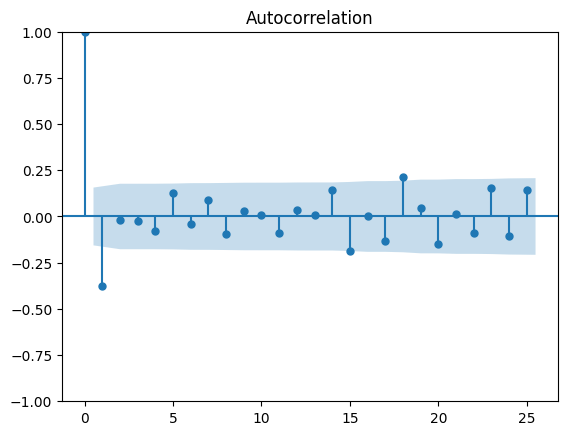

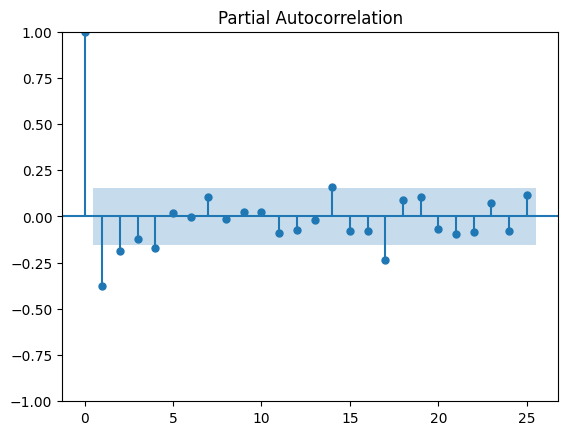

In [144]:
#Autocorrelação
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(acddes_sem['Qtd_Acidentes_Semana_1stDiff'], lags=25) 
plot_pacf(acddes_sem['Qtd_Acidentes_Semana_1stDiff'], lags=25) 
plt.show()

In [146]:
acd_sem.info()
acd_sem.head

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2017-01-01 to 2020-01-05
Freq: W-SUN
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Qtd_Acidentes_Semana  158 non-null    float64
 1   Decompozição_add      158 non-null    float64
 2   Decompozição_mult     158 non-null    float64
 3   Decompozição_STL      158 non-null    float64
dtypes: float64(4)
memory usage: 6.2 KB


<bound method NDFrame.head of               Qtd_Acidentes_Semana  Decompozição_add  Decompozição_mult  \
data_inversa                                                              
2017-01-01              314.000000        288.513812         282.835548   
2017-01-08              244.000000        253.194761         255.109029   
2017-01-15              254.285714        264.060389         266.775450   
2017-01-22              233.000000        247.746468         247.404564   
2017-01-29              226.285714        247.412858         248.286855   
...                            ...               ...                ...   
2019-12-08              201.142857        176.300742         179.682269   
2019-12-15              199.571429        169.452999         173.505366   
2019-12-22              225.428571        159.041612         169.261349   
2019-12-29              188.571429        163.085240         169.855743   
2020-01-05              164.000000        173.194761         171.46672

In [147]:
#Modelagem
#Proporção de dados de treino vs teste de 85/15

acd_arima = acd_sem['Qtd_Acidentes_Semana_1stDiff'].copy()
divisao = int(np.round(len(acd_arima)*0.15))

acd_treino = acd_arima.iloc[:-divisao]
acd_teste = acd_arima.iloc[-divisao:]

#Shapes
print("Shape do DF original:", acd_arima.shape)
print("Shape dos DFs de treino:", acd_treino.shape)
print("Shape dos DFs de teste:", acd_teste.shape)


Shape do DF original: (157,)
Shape dos DFs de treino: (133,)
Shape dos DFs de teste: (24,)


In [ ]:
#ARIMA
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(acd_treino, order = (5, 1, 14))
fit_modelo = modelo_arima.fit()

In [ ]:
fit_modelo.summary()

In [ ]:
#Predição sobre o conjunto de teste
inicio = len(acd_treino)
fim = len(acd_treino) + len(acd_teste) - 1
predicao = fit_modelo.predict(start = inicio,
                              end = fim,
                              typ = 'levels')
predicao.index = acd_arima.index[inicio:fim + 1]
print(predicao)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Cálculo dos Erros
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metricas(vreal, vpredito):
    mae = mean_absolute_error(vreal, vpredito)
    mse = mean_squared_error(vreal, vpredito)
    mape = mean_absolute_percentage_error(vreal, vpredito)
    rmse = np.round(np.sqrt(mse), decimals=2)
    print(f'MAE: {mae}','acidentes')
    print(f'MAPE: {mape}','% acidentes')
    print(f'MSE: {mse}','acidentes2')
    print(f'RMSE: {rmse}','acidentes')
metricas(acd_teste, predicao)

In [ ]:
#Gráfico de comparação dos valores reais com os preditos
acd_teste.plot(legend=True)
predicao.plot(legend=True, figsize=(15,6))
plt.show()